<a href="https://colab.research.google.com/github/dolmani38/Summary2/blob/main/multi-discriminator%20GAN%200516.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Discriminator GAN


ABSTRACT

----


#4. Implementation


## 4.1 기본 설정...

In [92]:
if True:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
#!pip install keybert
!pip install transformers
!pip install sentence-transformers

#!pip install sentence-transformers

In [94]:
import matplotlib.pyplot as plt
# set seeds for reproducability
from numpy.random import seed
#seed(1)

import pandas as pd
import numpy as np
import string, os 

import urllib.request
import nltk
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [95]:
import tensorflow as tf
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    print('GPU device not found')
    print(device_name)

Found GPU at: /device:GPU:0


In [96]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [97]:
# Print iterations progress
class ProgressBar:

    def __init__(self,total=20, prefix = '', suffix = '', decimals = 1, length = 20, fill = '|', printEnd = "\r"):
        self.total = total
        self.prefix = prefix
        self.suffix = suffix
        self.decimals = decimals
        self.length = length
        self.fill = fill
        self.printEnd = printEnd
        self.ite = 0
        self.back_filledLength = 0

    def printProgress(self,iteration, text):
        self.ite += iteration
        percent = ("{0:." + str(self.decimals) + "f}").format(100 * (self.ite / float(self.total)))
        filledLength = int(self.length * self.ite // self.total)
        bar = self.fill * filledLength + '.' * (self.length - filledLength)
        if filledLength > self.back_filledLength or percent == 100:
            print(f'\r{self.prefix} |{bar}| {percent}% {self.suffix}  {text}', end="", flush=True)
            # Print New Line on Complete
            if self.ite == self.total: 
                print()
        self.back_filledLength = filledLength    

In [98]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

##4.2 Grammar Discriminator Class

In [99]:
# coding=utf-8
# Copyright 2018 Google AI, Google Brain and Carnegie Mellon University Authors and the HuggingFace Inc. team and Jangwon Park
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
""" Tokenization classes for KoBert model."""


import logging
import os
import unicodedata
from shutil import copyfile

from transformers import PreTrainedTokenizer


logger = logging.getLogger(__name__)

VOCAB_FILES_NAMES = {"vocab_file": "tokenizer_78b3253a26.model",
                     "vocab_txt": "vocab.txt"}

PRETRAINED_VOCAB_FILES_MAP = {
    "vocab_file": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/tokenizer_78b3253a26.model",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/tokenizer_78b3253a26.model",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/tokenizer_78b3253a26.model"
    },
    "vocab_txt": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/vocab.txt",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/vocab.txt",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/vocab.txt"
    }
}

PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    "monologg/kobert": 512,
    "monologg/kobert-lm": 512,
    "monologg/distilkobert": 512
}

PRETRAINED_INIT_CONFIGURATION = {
    "monologg/kobert": {"do_lower_case": False},
    "monologg/kobert-lm": {"do_lower_case": False},
    "monologg/distilkobert": {"do_lower_case": False}
}

SPIECE_UNDERLINE = u'▁'


class KoBertTokenizer(PreTrainedTokenizer):
    """
        SentencePiece based tokenizer. Peculiarities:
            - requires `SentencePiece <https://github.com/google/sentencepiece>`_
    """
    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    pretrained_init_configuration = PRETRAINED_INIT_CONFIGURATION
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES

    def __init__(
            self,
            vocab_file,
            vocab_txt,
            do_lower_case=False,
            remove_space=True,
            keep_accents=False,
            unk_token="[UNK]",
            sep_token="[SEP]",
            pad_token="[PAD]",
            cls_token="[CLS]",
            mask_token="[MASK]",
            **kwargs):
        super().__init__(
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            **kwargs
        )

        # Build vocab
        self.token2idx = dict()
        self.idx2token = []
        with open(vocab_txt, 'r', encoding='utf-8') as f:
            for idx, token in enumerate(f):
                token = token.strip()
                self.token2idx[token] = idx
                self.idx2token.append(token)

        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")

        self.do_lower_case = do_lower_case
        self.remove_space = remove_space
        self.keep_accents = keep_accents
        self.vocab_file = vocab_file
        self.vocab_txt = vocab_txt

        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(vocab_file)

    @property
    def vocab_size(self):
        return len(self.idx2token)

    def get_vocab(self):
        return dict(self.token2idx, **self.added_tokens_encoder)

    def __getstate__(self):
        state = self.__dict__.copy()
        state["sp_model"] = None
        return state

    def __setstate__(self, d):
        self.__dict__ = d
        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(self.vocab_file)

    def preprocess_text(self, inputs):
        if self.remove_space:
            outputs = " ".join(inputs.strip().split())
        else:
            outputs = inputs
        outputs = outputs.replace("``", '"').replace("''", '"')

        if not self.keep_accents:
            outputs = unicodedata.normalize('NFKD', outputs)
            outputs = "".join([c for c in outputs if not unicodedata.combining(c)])
        if self.do_lower_case:
            outputs = outputs.lower()

        return outputs

    def _tokenize(self, text, return_unicode=True, sample=False):
        """ Tokenize a string. """
        text = self.preprocess_text(text)

        if not sample:
            pieces = self.sp_model.EncodeAsPieces(text)
        else:
            pieces = self.sp_model.SampleEncodeAsPieces(text, 64, 0.1)
        new_pieces = []
        for piece in pieces:
            if len(piece) > 1 and piece[-1] == str(",") and piece[-2].isdigit():
                cur_pieces = self.sp_model.EncodeAsPieces(piece[:-1].replace(SPIECE_UNDERLINE, ""))
                if piece[0] != SPIECE_UNDERLINE and cur_pieces[0][0] == SPIECE_UNDERLINE:
                    if len(cur_pieces[0]) == 1:
                        cur_pieces = cur_pieces[1:]
                    else:
                        cur_pieces[0] = cur_pieces[0][1:]
                cur_pieces.append(piece[-1])
                new_pieces.extend(cur_pieces)
            else:
                new_pieces.append(piece)

        return new_pieces

    def _convert_token_to_id(self, token):
        """ Converts a token (str/unicode) in an id using the vocab. """
        return self.token2idx.get(token, self.token2idx[self.unk_token])

    def _convert_id_to_token(self, index, return_unicode=True):
        """Converts an index (integer) in a token (string/unicode) using the vocab."""
        return self.idx2token[index]

    def convert_tokens_to_string(self, tokens):
        """Converts a sequence of tokens (strings for sub-words) in a single string."""
        out_string = "".join(tokens).replace(SPIECE_UNDERLINE, " ").strip()
        return out_string

    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A KoBERT sequence has the following format:
            single sequence: [CLS] X [SEP]
            pair of sequences: [CLS] A [SEP] B [SEP]
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens=False):
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.
        Args:
            token_ids_0: list of ids (must not contain special tokens)
            token_ids_1: Optional list of ids (must not contain special tokens), necessary when fetching sequence ids
                for sequence pairs
            already_has_special_tokens: (default False) Set to True if the token list is already formated with
                special tokens for the model
        Returns:
            A list of integers in the range [0, 1]: 0 for a special token, 1 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]

    def create_token_type_ids_from_sequences(self, token_ids_0, token_ids_1=None):
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A KoBERT sequence pair mask has the following format:
        0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
        | first sequence    | second sequence
        if token_ids_1 is None, only returns the first portion of the mask (0's).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]

    def save_vocabulary(self, save_directory):
        """ Save the sentencepiece vocabulary (copy original file) and special tokens file
            to a directory.
        """
        if not os.path.isdir(save_directory):
            logger.error("Vocabulary path ({}) should be a directory".format(save_directory))
            return

        # 1. Save sentencepiece model
        out_vocab_model = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_file"])

        if os.path.abspath(self.vocab_file) != os.path.abspath(out_vocab_model):
            copyfile(self.vocab_file, out_vocab_model)

        # 2. Save vocab.txt
        index = 0
        out_vocab_txt = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_txt"])
        with open(out_vocab_txt, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.token2idx.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".format(out_vocab_txt)
                    )
                    index = token_index
                writer.write(token + "\n")
                index += 1

        return out_vocab_model, out_vocab_txt

In [100]:
from transformers import BertTokenizer, AutoTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split

import time
import random
import datetime

# 간단한 전처리
def clean_text(txt):
    txt = txt.replace('\n',' ')
    txt = txt.replace('\r',' ')    
    txt = txt.replace('=','')
    txt = txt.replace('\"','')   
    txt = txt.replace('\'','')
    #txt = txt.replace(',','')
    txt = txt.replace('..','')
    txt = txt.replace('...','')
    txt = txt.replace(' .','.')
    txt = txt.replace('.','. ')
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')           
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')             
    return txt.strip()

def shuffling(txt):
    txt_list = txt.split(' ')
    random.shuffle(txt_list)
    return ' '.join(txt_list)

def collect_training_dataset_for_grammar_discriminator(sentences_dataset):

    sentences = []
    labels = []

    for txtss in sentences_dataset:
        txtss = clean_text(txtss)
        txts = txtss.strip().split('.')
        for txt in txts:  
            txt = txt.strip()
            if len(txt) > 40:
                #ko_grammar_dataset.append([txt,1])
                txt = txt.replace('.','')
                tf = random.choice([True,False])
                # 정상 또는 비정상 둘중에 하나만 데이터셋에 추가
                if (tf):
                    sentences.append(txt) # '.'의 위치를 보고 True, False를 판단 하기 땜에...
                    labels.append(1)
                else:
                    sentences.append(shuffling(txt))
                    labels.append(0)

    return sentences,labels

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

class Grammar_Discriminator:


    def __init__(self, pretraoned_kobert_model_name='monologg/kobert', input_dir=None):

        if input_dir is None:
            self.tokenizer = KoBertTokenizer.from_pretrained(pretraoned_kobert_model_name)
            self.discriminator = BertForSequenceClassification.from_pretrained(
                                    pretraoned_kobert_model_name, # Use the 12-layer BERT model, with an uncased vocab.
                                    num_labels = 2, # The number of output labels--2 for binary classification.
                                                    # You can increase this for multi-class tasks.   
                                    output_attentions = False, # Whether the model returns attentions weights.
                                    output_hidden_states = False, # Whether the model returns all hidden-states.
                                )            
        else:
            self.__load_model(input_dir)




    def set_dataset(self, sentences,labels):
        # Print the original sentence.
        print(' Original: ', sentences[0])

        # Print the sentence split into tokens.
        print('Tokenized: ', self.tokenizer.tokenize(sentences[0]))

        # Print the sentence mapped to token ids.
        print('Token IDs: ', self.tokenizer.convert_tokens_to_ids(self.tokenizer.tokenize(sentences[0])))   

        # Tokenize all of the sentences and map the tokens to thier word IDs.
        input_ids = []
        attention_masks = []

        # For every sentence...
        for sent in sentences:
            # `encode_plus` will:
            #   (1) Tokenize the sentence.
            #   (2) Prepend the `[CLS]` token to the start.
            #   (3) Append the `[SEP]` token to the end.
            #   (4) Map tokens to their IDs.
            #   (5) Pad or truncate the sentence to `max_length`
            #   (6) Create attention masks for [PAD] tokens.
            encoded_dict = self.tokenizer.encode_plus(
                                sent,                      # Sentence to encode.
                                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                max_length = 64,           # Pad & truncate all sentences.
                                pad_to_max_length = True,
                                return_attention_mask = True,   # Construct attn. masks.
                                return_tensors = 'pt',     # Return pytorch tensors.
                                truncation = True,
                        )
            
            # Add the encoded sentence to the list.    
            input_ids.append(encoded_dict['input_ids'])
            
            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_dict['attention_mask'])

        # Convert the lists into tensors.
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
        labels = torch.tensor(labels)

        # Print sentence 0, now as a list of IDs.
        print('Original: ', sentences[0])
        print('Token IDs:', input_ids[0])

        # Training & Validation Split
        # Divide up our training set to use 90% for training and 10% for validation.

        # Combine the training inputs into a TensorDataset.
        dataset = TensorDataset(input_ids, attention_masks, labels)

        # Create a 90-10 train-validation split.

        # Calculate the number of samples to include in each set.
        train_size = int(0.9 * len(dataset))
        val_size = len(dataset) - train_size

        # Divide the dataset by randomly selecting samples.
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        print('{:>5,} training samples'.format(train_size))
        print('{:>5,} validation samples'.format(val_size))

        # The DataLoader needs to know our batch size for training, so we specify it 
        # here. For fine-tuning BERT on a specific task, the authors recommend a batch 
        # size of 16 or 32.
        self.batch_size = 32

        # Create the DataLoaders for our training and validation sets.
        # We'll take training samples in random order. 
        self.train_dataloader = DataLoader(
                    train_dataset,  # The training samples.
                    sampler = RandomSampler(train_dataset), # Select batches randomly
                    batch_size = self.batch_size # Trains with this batch size.
                )

        # For validation the order doesn't matter, so we'll just read them sequentially.
        self.validation_dataloader = DataLoader(
                    val_dataset, # The validation samples.
                    sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                    batch_size = self.batch_size # Evaluate with this batch size.
                )        



    def train(self,epochs=4):
        # Tell pytorch to run this model on the GPU.
        self.discriminator.cuda()

        # Get all of the model's parameters as a list of tuples.
        params = list(self.discriminator.named_parameters())

        print('The BERT model has {:} different named parameters.\n'.format(len(params)))

        print('==== Embedding Layer ====\n')

        for p in params[0:5]:
            print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

        print('\n==== First Transformer ====\n')

        for p in params[5:21]:
            print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

        print('\n==== Output Layer ====\n')

        for p in params[-4:]:
            print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))  

        # Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
        # I believe the 'W' stands for 'Weight Decay fix"
        self.optimizer = AdamW(self.discriminator.parameters(),
                        lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                        eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                        )

        # Number of training epochs. The BERT authors recommend between 2 and 4. 
        # We chose to run for 4, but we'll see later that this may be over-fitting the
        # training data.
        #epochs = 2

        # Total number of training steps is [number of batches] x [number of epochs]. 
        # (Note that this is not the same as the number of training samples).
        total_steps = len(self.train_dataloader) * epochs

        # Create the learning rate scheduler.
        scheduler = get_linear_schedule_with_warmup(self.optimizer, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)
            
        # This training code is based on the `run_glue.py` script here:
        # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

        # Set the seed value all over the place to make this reproducible.
        seed_val = 42

        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)

        # We'll store a number of quantities such as training and validation loss, 
        # validation accuracy, and timings.
        training_stats = []

        # Measure the total training time for the whole run.
        total_t0 = time.time()

        # For each epoch...
        for epoch_i in range(0, epochs):
            
            # ========================================
            #               Training
            # ========================================
            
            # Perform one full pass over the training set.

            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
            print('Training...')

            # Measure how long the training epoch takes.
            t0 = time.time()

            # Reset the total loss for this epoch.
            total_train_loss = 0

            # Put the model into training mode. Don't be mislead--the call to 
            # `train` just changes the *mode*, it doesn't *perform* the training.
            # `dropout` and `batchnorm` layers behave differently during training
            # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
            self.discriminator.train()

            # For each batch of training data...
            for step, batch in enumerate(self.train_dataloader):

                # Progress update every 40 batches.
                if step % 40 == 0 and not step == 0:
                    # Calculate elapsed time in minutes.
                    elapsed = format_time(time.time() - t0)
                    
                    # Report progress.
                    print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(self.train_dataloader), elapsed))

                # Unpack this training batch from our dataloader. 
                #
                # As we unpack the batch, we'll also copy each tensor to the GPU using the 
                # `to` method.
                #
                # `batch` contains three pytorch tensors:
                #   [0]: input ids 
                #   [1]: attention masks
                #   [2]: labels 
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)

                # Always clear any previously calculated gradients before performing a
                # backward pass. PyTorch doesn't do this automatically because 
                # accumulating the gradients is "convenient while training RNNs". 
                # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
                self.discriminator.zero_grad()        

                # Perform a forward pass (evaluate the model on this training batch).
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # It returns different numbers of parameters depending on what arguments
                # arge given and what flags are set. For our useage here, it returns
                # the loss (because we provided labels) and the "logits"--the model
                # outputs prior to activation.
                loss, logits = self.discriminator(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask, 
                                    labels=b_labels)

                # Accumulate the training loss over all of the batches so that we can
                # calculate the average loss at the end. `loss` is a Tensor containing a
                # single value; the `.item()` function just returns the Python value 
                # from the tensor.
                total_train_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Clip the norm of the gradients to 1.0.
                # This is to help prevent the "exploding gradients" problem.
                torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), 1.0)

                # Update parameters and take a step using the computed gradient.
                # The optimizer dictates the "update rule"--how the parameters are
                # modified based on their gradients, the learning rate, etc.
                self.optimizer.step()

                # Update the learning rate.
                scheduler.step()

            # Calculate the average loss over all of the batches.
            avg_train_loss = total_train_loss / len(self.train_dataloader)            
            
            # Measure how long this epoch took.
            training_time = format_time(time.time() - t0)

            print("")
            print("  Average training loss: {0:.2f}".format(avg_train_loss))
            print("  Training epcoh took: {:}".format(training_time))
                
            # ========================================
            #               Validation
            # ========================================
            # After the completion of each training epoch, measure our performance on
            # our validation set.

            print("")
            print("Running Validation...")

            t0 = time.time()

            # Put the model in evaluation mode--the dropout layers behave differently
            # during evaluation.
            self.discriminator.eval()

            # Tracking variables 
            total_eval_accuracy = 0
            total_eval_loss = 0
            nb_eval_steps = 0

            # Evaluate data for one epoch
            for batch in self.validation_dataloader:
                
                # Unpack this training batch from our dataloader. 
                #
                # As we unpack the batch, we'll also copy each tensor to the GPU using 
                # the `to` method.
                #
                # `batch` contains three pytorch tensors:
                #   [0]: input ids 
                #   [1]: attention masks
                #   [2]: labels 
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)
                
                # Tell pytorch not to bother with constructing the compute graph during
                # the forward pass, since this is only needed for backprop (training).
                with torch.no_grad():        

                    # Forward pass, calculate logit predictions.
                    # token_type_ids is the same as the "segment ids", which 
                    # differentiates sentence 1 and 2 in 2-sentence tasks.
                    # The documentation for this `model` function is here: 
                    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                    # Get the "logits" output by the model. The "logits" are the output
                    # values prior to applying an activation function like the softmax.
                    (loss, logits) = self.discriminator(b_input_ids, 
                                        token_type_ids=None, 
                                        attention_mask=b_input_mask,
                                        labels=b_labels)
                    
                # Accumulate the validation loss.
                total_eval_loss += loss.item()

                # Move logits and labels to CPU
                logits = logits.detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()

                # Calculate the accuracy for this batch of test sentences, and
                # accumulate it over all batches.
                total_eval_accuracy += flat_accuracy(logits, label_ids)
                

            # Report the final accuracy for this validation run.
            avg_val_accuracy = total_eval_accuracy / len(self.validation_dataloader)
            print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

            # Calculate the average loss over all of the batches.
            avg_val_loss = total_eval_loss / len(self.validation_dataloader)
            
            # Measure how long the validation run took.
            validation_time = format_time(time.time() - t0)
            
            print("  Validation Loss: {0:.2f}".format(avg_val_loss))
            print("  Validation took: {:}".format(validation_time))

            # Record all statistics from this epoch.
            training_stats.append(
                {
                    'epoch': epoch_i + 1,
                    'Training Loss': avg_train_loss,
                    'Valid. Loss': avg_val_loss,
                    'Valid. Accur.': avg_val_accuracy,
                    'Training Time': training_time,
                    'Validation Time': validation_time
                }
            )

        print("")
        print("Training complete!")

        print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
            

        return training_stats

    def save_model(self, output_dir = './model_save/'):
        # Create output directory if needed
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        print("Saving model to %s" % output_dir)

        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        model_to_save = self.discriminator.module if hasattr(self.discriminator, 'module') else self.discriminator  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        self.tokenizer.save_pretrained(output_dir)

        # Good practice: save your training arguments together with the trained model
        # torch.save(args, os.path.join(output_dir, 'training_args.bin'))

    def __load_model(self, input_dir = './drive/MyDrive/Colab Notebooks/summary/en_grammar_check_model'):
        print('Loading BERT tokenizer...')
        self.tokenizer = KoBertTokenizer.from_pretrained(input_dir)
        self.discriminator = BertForSequenceClassification.from_pretrained(input_dir)

    def transfer_learning(self, sentences, train_for = True):
        
        input_ids = []
        attention_masks = []

        # For every sentence...
        for sent in sentences:
            # `encode_plus` will:
            #   (1) Tokenize the sentence.
            #   (2) Prepend the `[CLS]` token to the start.
            #   (3) Append the `[SEP]` token to the end.
            #   (4) Map tokens to their IDs.
            #   (5) Pad or truncate the sentence to `max_length`
            #   (6) Create attention masks for [PAD] tokens.
            encoded_dict = self.tokenizer.encode_plus(
                                sent,                      # Sentence to encode.
                                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                max_length = 64,           # Pad & truncate all sentences.
                                pad_to_max_length = True,
                                return_attention_mask = True,   # Construct attn. masks.
                                return_tensors = 'pt',     # Return pytorch tensors.
                                truncation = True,
                        )
            # Add the encoded sentence to the list.    
            input_ids.append(encoded_dict['input_ids'])

            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_dict['attention_mask'])
        
        if train_for:
            b_labels = torch.ones(len(sentences),dtype=torch.long).to(device)
        else:
            b_labels = torch.zeros(len(sentences),dtype=torch.long).to(device)
        #print(b_labels)
        # Convert the lists into tensors.
        input_ids = torch.cat(input_ids, dim=0).to(device)
        attention_masks = torch.cat(attention_masks, dim=0).to(device)    
        #if str(discriminator1.device) == 'cpu':
        #    pass
        #else:
        #    input_ids = input_ids.to(device)
        #    attention_masks = attention_masks.to(device)        

        outputs = self.discriminator(input_ids, 
                            token_type_ids=None, 
                            attention_mask=attention_masks, 
                                labels=b_labels)

        #print(outputs)
        #return torch.sigmoid(outputs[0][:,1])
        #return outputs[0][:,1]
        return outputs['loss'], outputs['logits']


# 문법 학습을 위한 데이터셋 구성

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/summary/korean_news_corpus.csv')
df

,title,contents
0,문 대통령 변창흠 국토장관 사의표명 사실상 수용,정만호 국민소통수석이 12일 오후 청와대 춘추관 대브리핑룸에서 변창흠 국토부 장관 ...
1,계급장 수여하는 문 대통령,(아산뉴스1) 이광호 기자 문재인 대통령이 12일 오후 충남 아산시 경찰대학에서 열...
2,계급장 수여하는 문 대통령,(아산뉴스1) 이광호 기자 문재인 대통령이 12일 오후 충남 아산시 경찰대학에서 열...
3,수상자 메달 걸어주는 문 대통령,(아산뉴스1) 이광호 기자 문재인 대통령이 12일 오후 충남 아산시 경찰대학에서 열...
4,정몽구 서울아산병원에 50억 쾌척,인재 양성·소외 계층 지원 등 계획 “부친 질병·가난 악순환 끊기 원해 국내 최고 ...
...,...,...
140559,[건축과도시] 북한산을 캔버스 삼아. 미술관 또 하나의 작품이 되다,<은평구 진관동 사비나 미술관> 서울시 은평구 진관동에 자리잡은 사비나미술관. 삼각...
140560,조선후기 문인 김조순 별장 그린 옥호정도 첫 공개,국립중앙박물관 서화실 개편해 32점 새롭게 전시 옥호정도[국립중앙박물관 제공연합뉴스...
140561,안성 청룡사 대웅전에서 목재 곡자 발견,문화재청(청장 정재숙)의 국고보조와 기술지도로 안성시에서 시행하고 있는 안성 청룡사...
140562,156년전 ㄱ자 곡자 찾았다 안성 청룡사 기둥 밑에서,안성 청룡사 대웅전에서 발견된 곡자 【서울뉴시스】 이수지 기자 안성 청룡사 대웅전에...


In [ ]:
df = df.dropna(axis=0)
df['contents'].count()

140536

In [ ]:
import re
import sys

import nltk
nltk.download('punkt')

# 간단한 전처리
def clean_text(txt):
    txt = txt.replace('\n',' ')
    txt = txt.replace('\r',' ')    
    txt = txt.replace('=','')
    txt = txt.replace('\"','')   
    txt = txt.replace('\'','')
    #txt = txt.replace(',','')
    txt = txt.replace('..','')
    txt = txt.replace('...','')
    #txt = txt.replace('.','. ')
    txt = txt.replace('.','. ')
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')           
    txt = txt.replace('  ',' ')
    txt = txt.replace('  ',' ')    
    txt = txt.replace('  ',' ')   
    txt = txt.replace('  ',' ')             
    return txt.strip()
    
# 검사...
pattens = ["[34569][0-9]{3}[\;.\;-\; ][0-9]{4}[\;.\;-\; ][0-9]{4}[\;.\;-\; ][0-9]{4}",
           "[0-9]{2,3}[\:\s\;.\;,\;-;)][0-9]{3,4}[\:\s\;.\;,\;-][0-9]{4}",
           "[0-9]{1}[0-9]{1}[\W]?[0-1]{1}[0-9]{1}[\W]?[0-3]{1}[\W]?[0-9]{1}[\W]?[1-4]{1}[\W]?[0-9]{1}[\W]?[0-9]{1}[\W]?[0-9]{1}[\W]?[0-9]{1}[\W]?[0-9]{1}[\W]?[0-9]{1}",
           "[0-9]{2}[\:\s\;.\;,\;-][0-9]{2}[\:\s\;.\;,\;-][0-9]{6}|[0-9]{3}[\:\s\;.\;,\;-]([0-9]{5,6}[\:\s\;.\;,\;-][0-9]{3}|[0-9]{6}[\:\s\;.\;,\;-][0-9]{5}|[0-9]{2,3}[\:\s\;.\;,\;-][0-9]{6}|[0-9]{2}[\:\s\;.\;,\;-][0-9]{7}|[0-9]{2}[\:\s\;.\;,\;-][0-9]{4,6}[\:\s\;.\;,\;-][0-9]|[0-9]{5}[\:\s\;.\;,\;-][0-9]{3}[\:\s\;.\;,\;-][0-9]{2}|[0-9]{2}[\:\s\;.\;,\;-][0-9]{5}[\:\s\;.\;,\;-][0-9]{3}|[0-9]{4}[\:\s\;.\;,\;-][0-9]{4}[\:\s\;.\;,\;-][0-9]{3}|[0-9]{6}[\:\s\;.\;,\;-][0-9]{2}[\:\s\;.\;,\;-][0-9]{3}|[0-9]{2}[\:\s\;.\;,\;-][0-9]{2}[\:\s\;.\;,\;-][0-9]{7})|[0-9]{4}[\:\s\;.\;,\;-]([0-9]{3}[\:\s\;.\;,\;-][0-9]{6}|[0-9]{2}[\:\s\;.\;,\;-][0-9]{6}[\:\s\;.\;,\;-][0-9])|[0-9]{5}[\:\s\;.\;,\;-][0-9]{2}[\:\s\;.\;,\;-][0-9]{6}|[0-9]{6}[\:\s\;.\;,\;-][0-9]{2}[\:\s\;.\;,\;-][0-9]{5,6}"
           ]

filters = []
for p in pattens:
    filters.append(re.compile(p))

sentences = []
df = df.dropna(axis=0)
cnt = df['contents'].count()
#print('Total row count:',cnt)
i=0
for raw_text in df['contents']:
    i=i+1
    try:
        if i%100 == 0:
            percent = ("{0:.2f}").format(100 * (i / float(cnt)))
            print(f'\r {percent}% {i}/{str(cnt)}', end="", flush=True)

        docs = nltk.sent_tokenize(clean_text(raw_text))
        for txt in docs:
            if txt.find('▶') > -1 or txt.find('@') > -1 or txt.find('ⓒ') > -1: 
                pass
            else:
                txt = txt.strip()
                if any(chr.isdigit() for chr in txt) :
                    pass
                else:
                    sentences.append(txt)
    except KeyboardInterrupt as ki:
        raise ki        
    except:
        pass #print("Unexpected error:", sys.exc_info()[0])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
 99.97% 140500/140536

In [ ]:
import re
import sys
import io

#텍스트 정제(전처리)
def cleanText(readData):
    #텍스트에 포함되어 있는 특수 문자 제거
    text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》◆◇●🎧○▲\t―△━▷]', '', readData)
    return text

In [ ]:

c_sentences = []
for sentence in sentences:
    s = cleanText(sentence)
    c = len(s.split())
    if c >= 3 and c < 10 and s.find('재배포') < 0 and s.find('기자') < 0  and s.find('유투브') < 0 and s.find('www') < 0 and s.find('com') < 0 and s.find('접속하기') < 0 and s.find('http') < 0 and s.find('뉴스') < 0 and s.find('일보') < 0 :
        if s.endswith(('다','요')):
            c_sentences.append(s.strip())

In [ ]:
len(c_sentences)

867766

In [ ]:
c_sentences[:100]

['그동안 팔아치웠던 삼성전자와 SK하이닉스 등 반도체주를 다시 담기 시작했다',
 '조정장에서 순매수했던 삼성화재와 SK텔레콤은 더 많이 사들였다',
 '반면 빅히트 등에 대해서는 순매도를 이어갔다',
 '김성수 과학기술정보통신부 과학기술혁신본부장이 인사말을 하고 있다',
 '김성수 과학기술정보통신부 과학기술혁신본부장이 인사말을 하고 있다',
 '김성수 과학기술정보통신부 과학기술혁신본부장이 간담회 참석자들과 기념촬영 하고 있다',
 '충격적인 일”이라고 주장했다',
 '내가 엉터리 보도의 현장 증인이다',
 '지상최대의 이간 작전이 시작됐다”고 말했다',
 'A씨는 취재진의 질문에 “딸이 낳은 아이가 맞다',
 '나는 아이를 낳은 적이 없다”고 말했다',
 '지속적인 손바뀜이 일어나고 있는 것 같아요',
 '지금 미국 정부가 하고 있는 부양책의 핵심은 고용이거든요',
 '이렇게 되면 기술주보다는 전통 산업 쪽으로 움직여야 할 것입니다',
 '연준도 물가 올라간다는 건 인정해요',
 '연준은 지금 평균 물가 목표제를 갖고 있거든요',
 '지속성이 있을 것 같다는 쪽에 비중을 많이 두는 편입니다',
 '비용이 최소가 되는 겁니다',
 '이걸 친환경으로 바꾸면서 아무래도 비용이 증가할 수밖에 없습니다',
 '최소한 올해 가을은 되어야 확인할 수 있어요',
 '그렇기 때문에 지금 시장이 어느 쪽 이야기를 믿어주느냐가 중요합니다',
 '하지만 최근에는 유가나 구리가 조금 안정되었어요',
 '지금은 일시적이라는 생각들이 많은 것 같아요',
 '채권의 매수 여력이 현저히 약화된 것으로 보입니다',
 '그런데 장기 채권에서는 연기금으로부터 꾸준하게 돈이 들어오고 있어요',
 '코로나 대응 채권 매입속도 높인다',
 '이전에 연준은 물가와 GDP성장률을 확실한 목표로 잡고 있었어요',
 '파월의장도 그 점을 작년에 다시 확인을 했습니다',
 '지금 미국의 GDP성장률이 올해 굉장히 높게 나올 것 같아요',
 '그러면 계속 부양하겠다는게 연준이 정해놓은 목표입니다',
 '고용

# 문법 discriminator의 학습

In [ ]:
ko_sentences_dataset = c_sentences

In [101]:
use_pretrained_model = True

if use_pretrained_model:
    #g_discriminator = Grammar_Discriminator(input_dir = '/content/drive/MyDrive/Colab Notebooks/summary/model_save')
    g_discriminator = Grammar_Discriminator(input_dir = '/content/drive/MyDrive/Colab Notebooks/summary/ko_grammar_model2')
else:
    sentences,labels = collect_training_dataset_for_grammar_discriminator(ko_sentences_dataset)
    print(len(sentences))
    g_discriminator = Grammar_Discriminator()
    g_discriminator.set_dataset(sentences,labels)
    g_discriminator.train(epochs=1)
    g_discriminator.save_model(output_dir='/content/drive/MyDrive/Colab Notebooks/summary/ko_grammar_model2')

Loading BERT tokenizer...


In [ ]:
if False: ## 추가적인 fine-tuning
    #sentences,labels = collect_training_dataset_for_grammar_discriminator(ko_sentences_dataset)
    #print(len(sentences))
    #g_discriminator = Grammar_Discriminator()
    #g_discriminator.set_dataset(sentences,labels)
    g_discriminator.train(epochs=2)
    g_discriminator.save_model(output_dir='/content/drive/MyDrive/Colab Notebooks/summary/ko_grammar_model2')

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                   (8002, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [102]:
txt = ['최근 날씨가 포근해지면서 산을 찾는 사람들도 늘고 있는데요','서비스를 음원 플랫폼 스포티파이가 국내  론칭한다']
g_discriminator.discriminator.to(device)
g_discriminator.transfer_learning(txt)

(tensor(3.9366, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor([[-4.5302,  4.1747],
         [ 4.0265, -3.8462]], device='cuda:0', grad_fn=<AddmmBackward>))

## 문장완성 구분 discriminator

In [12]:

def ellipsis(txt):
    txt_list = txt.split(' ')
    elp = random.sample(txt_list,k=random.randint(1,len(txt_list)-1))
    #print(elp)
    for e in elp:
        txt_list.remove(e)
    return ' '.join(txt_list)

def collect_training_dataset_for_complete_discriminator(sentences_dataset):

    sentences = []
    labels = []

    for txtss in sentences_dataset:
        txtss = clean_text(txtss)
        txts = txtss.strip().split('.')
        try:
            for txt in txts:  
                txt = txt.strip()
                if len(txt) > 40:
                    #ko_grammar_dataset.append([txt,1])
                    txt = txt.replace('.','')
                    tf = random.choice([True,False])
                    # 정상 또는 비정상 둘중에 하나만 데이터셋에 추가
                    if (tf):
                        sentences.append(txt) # '.'의 위치를 보고 True, False를 판단 하기 땜에...
                        labels.append(1)
                    else:
                        sentences.append(ellipsis(txt))
                        labels.append(0)
        except Exception as ex:
            pass
            
    return sentences,labels

In [ ]:
ellipsis('최근 날씨가 포근해지면서 산을 찾는 사람들도 늘고 있는데요')

['산을', '사람들도', '찾는', '포근해지면서']


'최근 날씨가 늘고 있는데요'

In [103]:
use_pretrained_model = True

if use_pretrained_model:
    c_discriminator = Grammar_Discriminator(input_dir = '/content/drive/MyDrive/Colab Notebooks/summary/ko_complete_model')
else:
    sentences,labels = collect_training_dataset_for_complete_discriminator(ko_sentences_dataset)
    print(len(sentences))
    c_discriminator = Grammar_Discriminator()
    c_discriminator.set_dataset(sentences,labels)
    c_discriminator.train(epochs=1)
    c_discriminator.save_model(output_dir='/content/drive/MyDrive/Colab Notebooks/summary/ko_complete_model')

Loading BERT tokenizer...


In [104]:
txt = ['최근 날씨가 포근해지면서 산을 찾는 사람들도 늘고 있는데요','서비스를 음원 플랫폼 스포티파이가 국내 론칭한다']
c_discriminator.discriminator.to(device)
c_discriminator.transfer_learning(txt)

(tensor(7.2445, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor([[ 3.3697, -3.4418],
         [ 3.8260, -3.8498]], device='cuda:0', grad_fn=<AddmmBackward>))

In [ ]:
if False: ## 추가적인 fine-tuning
    c_discriminator.train(epochs=2)
    c_discriminator.save_model(output_dir='/content/drive/MyDrive/Colab Notebooks/summary/ko_complete_model')

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                   (8002, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

##4.3 Static similarity discriminator class

In [105]:
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
import scipy


class Similarity_Discriminator:
    '''
    _instance = None
    _embedder = None
    def __new__(cls,pre_trained_model_name='stsb-roberta-large'):
        if cls._instance is None:
            print('Creating Similarity_Discriminator object')
            cls._instance = super(Similarity_Discriminator, cls).__new__(cls)
            # Put any initialization here.
            cls._embedder = SentenceTransformer(pre_trained_model_name)
        return cls._instance

    '''

    def __init__(self,pre_trained_model_name='xlm-r-large-en-ko-nli-ststb'):
        print('Creating Similarity_Discriminator object')
        # Put any initialization here.
        self._embedder = SentenceTransformer(pre_trained_model_name)  
        #self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)

    def encode(self,texts):
        return self._embedder.encode(texts,show_progress_bar=False)

    def similarity(self, query_text, org_text_emb):
        queries = nltk.sent_tokenize(query_text)
        query_embeddings = self._embedder.encode(queries,show_progress_bar=False)
        #query_embeddings = self._embedder.encode(queries,show_progress_bar=False)
        #print(queries)
        #print(org_text_emb)
        
        if len(query_embeddings) == 0:
            return 0.0

        cos_scores = scipy.spatial.distance.cdist(query_embeddings, org_text_emb, "cosine")
        similarity_score = 1.0 - np.mean(np.min(cos_scores,axis=0))
        '''
        for query, query_embedding in zip(queries, query_embeddings):
            distances = scipy.spatial.distance.cdist([query_embedding], [org_text_emb], "cosine")[0]
            results = zip(range(len(distances)), distances)
            for idx, distance in results:
                scores.append(1-distance)
        '''
        return similarity_score  
 

###4.3.1 한국어 문장 유사도 pre-trained model 적용

In [106]:
s_discriminator = Similarity_Discriminator()
#s_discriminator = Similarity_Discriminator()

Creating Similarity_Discriminator object


##4.4 Document source class

###4.4.1 keyBERT를 위한 pre-trained model의 적재

In [16]:
#!pip install keybert

In [17]:
#from keybert import KeyBERT
#key_model = KeyBERT('distilbert-base-nli-mean-tokens')

###4.4.2 frame term 추출을 위한 source class 구현

In [107]:


class Source:

    def __init__(self,org_text):
        self.org_text = org_text

    def __crean_text(self, txt):
        txt = txt.replace('\n',' ')
        txt = txt.replace('\r',' ')    
        txt = txt.replace('=','')
        txt = txt.replace('\"','')   
        txt = txt.replace('\'','')
        #txt = txt.replace(',','')
        txt = txt.replace('..','')
        txt = txt.replace('...','')
        txt = txt.replace(' .','.')
        txt = txt.replace('.','. ')
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')           
        txt = txt.replace('  ',' ')
        txt = txt.replace('  ',' ')    
        txt = txt.replace('  ',' ')   
        txt = txt.replace('  ',' ')           
        return txt.strip()


    def extract_keywords(self,s_discriminator,key_model,comp_rate=0.2):
        self.org_text = self.__crean_text(self.org_text.strip())
        print('------------------------------------------------------------------')
        print(self.org_text)
        print('------------------------------------------------------------------')
        self.org_sentences = np.array(nltk.sent_tokenize(self.org_text))
        self.org_term_set = (' ' + self.org_text + ' ').split(' ')
        self.org_source_length = len(self.org_term_set)
        self.term_table = {}
        #morp_table = {}
        index_table = {}
        for index, word in zip(range(len(self.org_term_set)),self.org_term_set):
            self.term_table[index] = word
        '''
        print('Token table of origin text')
        print('---------------------------------------------')
        print(' Code     Token     ')
        for k in self.term_table.keys():
            print( f'  {str(k).ljust(5)}     {self.term_table[k]}')
        print('---------------------------------------------')
        '''
        self.s_discriminator = s_discriminator
        # 원문의 embedding...
        self.org_text_emb = self.s_discriminator.encode(self.org_sentences)
        '''
        # weight 들의 초기화
        terms = np.array(list(self.term_table.values()))

        word_filters=np.array([[0]])

        story_weights = np.zeros(self.org_source_length,)
        word_weights = np.zeros(self.org_source_length,)

        #terms = np.array(list(self.term_table.values()))

        # story에 지배적인 word를 찾는다.
        # 먼저 word의 강세 분석
        for filter in word_filters:
            #print(filter)
            last_idx = len(terms)-(max(filter)+1)
            pb = ProgressBar(last_idx,prefix='Frame token scan:')
            for conv in range(last_idx,0,-1):
                pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                t = np.array(filter) + conv
                part_sen = ' '.join(terms[t]) 
                #print('\n part_sen:',part_sen)
                score = self.s_discriminator.similarity(part_sen.strip(),self.org_text_emb)
                word_weights[t] += score 

        # story의 강세 분석
        for filter in story_filters:
            #print(filter)
            last_idx = len(terms)-(max(filter)+1)
            pb = ProgressBar(last_idx,prefix='Frame token scan:')
            for conv in range(last_idx,0,-1):
                pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                t = np.array(filter) + conv
                part_sen = ' '.join(terms[t]) 
                score = self.s_discriminator.similarity(part_sen.strip(),self.org_text_emb)
                story_weights[t] += score

        #각각의 peak를 산출
        word_peaks, _ = find_peaks(word_weights, height=0)
        story_peaks, _ = find_peaks(story_weights, height=0)

        #두개의 peak가 겹치는 word에 대해 한개 word가 유사도에 미치는 영향이 큰것으로 간주
        #해당 word를 유사도 판단 필터에서 제외하고 다시 필터링...
        #이를 통해 story에 대한 word를 최대한 추출 한다.

        dup_order = []
        for i in range(self.org_source_length):
            #lst = ""
            if (i in word_peaks) and (i in story_peaks):
                if terms[i].endswith('.'):
                    pass
                else:
                    dup_order.append(i)
                    
        # Story에 대한 weight을 추출하기 위해, word에 유독 강세가 있는 term을 제외 시킨다.
        print('Negative tokens:',terms[dup_order])
        '''

        top_n = int(len(self.term_table) * comp_rate)

        self.story_peaks = []
        keywords = key_model.extract_keywords(self.org_text,top_n=top_n)
        #print('keywords len',len(keywords))
        #print('keywords',keywords)
        for keyword,p in keywords:
            for k in self.term_table.keys():
                if self.term_table[k] == keyword: # and k not in dup_order:
                    self.story_peaks.append(k)

        self.story_peaks.append(len(self.term_table)-2)
        self.story_peaks = np.sort(np.asarray(self.story_peaks))
        print('story_peaks:',self.story_peaks)
        print('Peak count:',len(self.story_peaks))          


        # story skeleton 추출
        self.frame_text = ""
        for k in self.story_peaks:
            #print(k,term_weight[k],word_table[k])
            self.frame_text += self.term_table[k]+' '  

        print('Frame tokens:',self.frame_text)
        print('')
        print(f'Similarity : {self.s_discriminator.similarity(self.frame_text.strip(),self.org_text_emb)}')    

    def set_key_rate(self,s_discriminator,comp_rate=0.2):
        self.org_text = self.__crean_text(self.org_text.strip())
        print('------------------------------------------------------------------')
        print(self.org_text)
        print('------------------------------------------------------------------')
        self.org_sentences = np.array(nltk.sent_tokenize(self.org_text))
        self.org_term_set = (' ' + self.org_text + ' ').split(' ')
        self.org_source_length = len(self.org_term_set)
        self.term_table = {}
        #morp_table = {}

        for index, word in zip(range(len(self.org_term_set)),self.org_term_set):
            self.term_table[index] = word

        self.s_discriminator = s_discriminator
        # 원문의 embedding...
        self.org_text_emb = self.s_discriminator.encode(self.org_sentences)
        top_n = int(len(self.term_table) * comp_rate)
        #print('top_n',top_n)
        self.story_peaks = [i+1 for i in range(top_n)]

    def analysis_frame_terms(self,s_discriminator,story_filters=np.array([[0,1],[0,1,2],[0,1,2,3]]),peak_base_line = 0.0,comp_rate=0.2,except_key=True,display=False):

        self.org_text = self.__crean_text(self.org_text.strip())
        print('------------------------------------------------------------------')
        print(self.org_text)
        print('------------------------------------------------------------------')
        self.org_sentences = np.array(nltk.sent_tokenize(self.org_text))
        self.org_term_set = (' ' + self.org_text + ' ').split(' ')
        self.org_source_length = len(self.org_term_set)
        self.term_table = {}
        #morp_table = {}

        for index, word in zip(range(len(self.org_term_set)),self.org_term_set):
            self.term_table[index] = word
        '''
        print('Token table of origin text')
        print('---------------------------------------------')
        print(' Code     Token     ')
        for k in self.term_table.keys():
            print( f'  {str(k).ljust(5)}     {self.term_table[k]}')
        print('---------------------------------------------')
        '''

        self.s_discriminator = s_discriminator
        # 원문의 embedding...
        self.org_text_emb = self.s_discriminator.encode(self.org_sentences)

        # weight 들의 초기화
        terms = np.array(list(self.term_table.values()))

        word_filters=np.array([[0]])

        story_weights = np.zeros(self.org_source_length,)
        word_weights = np.zeros(self.org_source_length,)

        #terms = np.array(list(self.term_table.values()))

        if except_key:
            # story에 지배적인 word를 찾는다.
            # 먼저 word의 강세 분석
            for filter in word_filters:
                #print(filter)
                last_idx = len(terms)-(max(filter)+1)
                pb = ProgressBar(last_idx,prefix='Frame token scan:')
                for conv in range(last_idx,0,-1):
                    pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                    t = np.array(filter) + conv
                    part_sen = ' '.join(terms[t]) 
                    score = self.s_discriminator.similarity(part_sen.strip(),self.org_text_emb)
                    word_weights[t] += score 

            # story의 강세 분석
            for filter in story_filters:
                #print(filter)
                last_idx = len(terms)-(max(filter)+1)
                pb = ProgressBar(last_idx,prefix='Frame token scan:')
                for conv in range(last_idx,0,-1):
                    pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                    t = np.array(filter) + conv
                    part_sen = ' '.join(terms[t]) 
                    score = self.s_discriminator.similarity(part_sen.strip(),self.org_text_emb)
                    story_weights[t] += score

            #각각의 peak를 산출
            word_peaks, _ = find_peaks(word_weights, height=0)
            story_peaks, _ = find_peaks(story_weights, height=0)

            #두개의 peak가 겹치는 word에 대해 한개 word가 유사도에 미치는 영향이 큰것으로 간주
            #해당 word를 유사도 판단 필터에서 제외하고 다시 필터링...
            #이를 통해 story에 대한 word를 최대한 추출 한다.

            dup_order = []
            for i in range(self.org_source_length):
                #lst = ""
                if (i in word_peaks) and (i in story_peaks):
                    if terms[i].endswith('.'):
                        pass
                    else:
                        dup_order.append(i)
                        
            # Story에 대한 weight을 추출하기 위해, word에 유독 강세가 있는 term을 제외 시킨다.
            print('Negative tokens:',terms[dup_order])
            if except_key:
                terms[dup_order] = '---'
        '''
        print('Token table of origin text')
        print('---------------------------------------------')
        print(' Code         Token      ')
        print('')
        for index, word in zip(range(len(terms)),terms):
            print( f'  {str(index).ljust(8)}    {word}')
        print('---------------------------------------------')
        '''
        self.story_weights = np.zeros(self.org_source_length,)
        # 그리고 다시 story 분석 스캔
        for filter in story_filters:
            #print(filter)
            last_idx = len(terms)-(max(filter)+1)
            pb = ProgressBar(last_idx,prefix='Frame token scan:')
            for conv in range(last_idx):
                pb.printProgress(+1,f'filer:{filter} {conv}/{last_idx}       ')
                t = np.array(filter) + conv
                part_sen = ' '.join(terms[t]) 
                #part_sen = part_sen.replace('소녀','---')
                score = self.s_discriminator.similarity(part_sen.strip(),self.org_text_emb)
                self.story_weights[t] += score        


        # base line
        base_line = peak_base_line
        # 다시 peak 추출
        story_peaks, _ = find_peaks(self.story_weights, height=base_line)

        top_n = int(len(self.term_table) * comp_rate)

        if len(story_peaks) > top_n:
            peak_dict = {}
            for i,peak in zip(range(len(story_peaks)),story_peaks):
                peak_dict[peak] = self.story_weights[peak]
            #print(peak_dict)
            peaks = sorted(peak_dict, key=peak_dict.get, reverse=True)
            #print(peaks)
            peaks = peaks[:top_n]
            #print(peaks)
            peaks.sort()
            story_peaks = peaks
            #print(story_peaks)

        #print('top_n:',top_n,'story_peaks:',len(story_peaks))
        #print(story_peaks)
        
        self.story_peaks = np.append(story_peaks,len(story_weights)-2)
        #print(self.story_peaks)
        # story density 표출
        if display:
            plt.figure(figsize=(12, 6))
            plt.plot(self.story_weights)
            plt.plot(self.story_peaks, self.story_weights[self.story_peaks], "x")
            plt.plot(np.zeros_like(self.story_weights)+base_line, "--", color="gray")
            plt.show() 
        print('Peak count:',len(self.story_peaks))          


        # story skeleton 추출
        self.frame_text = ""
        for k in self.story_peaks:
            #print(k,term_weight[k],word_table[k])
            self.frame_text += self.term_table[k]+' '  

        print('Frame tokens:',self.frame_text)
        print('')
        print(f'Similarity : {self.s_discriminator.similarity(self.frame_text.strip(),self.org_text_emb)}')      
        ''' 
        for index, word in zip(range(len(self.org_term_set)),self.org_term_set):
            self.term_table[index] = word
   
        print('Token table of origin text')
        print('---------------------------------------------')
        print(' Code     Score        Token              ')
        print('')
        for k in self.term_table.keys(): 
            print( f'  {str(k).ljust(5)}   {str(round(self.story_weights[k],4)).ljust(8)}  {self.term_table[k]}')

        print('---------------------------------------------') 
        '''
    def get_org_sample(self, num):
        return self.org_sentences[np.random.choice(len(self.org_sentences), num)]

    def get_source_embedded_code(self):
        return self.org_text_emb

##4.5 Generator class

In [108]:
from functools import reduce

class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=1024):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, input_size*2),
            nn.LeakyReLU(0.2),
            nn.Linear(input_size*2, input_size*3),
            nn.LeakyReLU(0.2),
            nn.Linear(input_size*3, input_size*3),
            nn.LeakyReLU(0.2),            
            nn.Linear(input_size*3, input_size*2),
            nn.LeakyReLU(0.2),
            nn.Linear(input_size*2, input_size),
            #nn.BatchNorm1d(term_length*4),
            nn.Tanh() # -1 ~ 1
        )
    '''
    def forward(self, x, story_peaks, bias):
        #biased_noise = torch.randn(N,_NOISE_DIM)
        # stroy peak에 해당하는 term에게 평균값에 해당하는 bias를 추가 한다.
                 
        y_ = self.layer(x)
        y_[:,story_peaks] += bias
        y_ = nn.Sigmoid()(y_)
        #reduce(torch.add, [y_,bias]) / 2
        return y_
    '''

    
    def forward(self, x, bias):
        #biased_noise = torch.randn(N,_NOISE_DIM)
        # stroy peak에 해당하는 term에게 평균값에 해당하는 bias를 추가 한다.
                 
        y_ = self.layer(x)
        y = torch.add(y_,bias)
        #y = nn.Sigmoid()(y)

        return y, y_

    '''    
    def forward(self, x):
        #biased_noise = torch.randn(N,_NOISE_DIM)
        # stroy peak에 해당하는 term에게 평균값에 해당하는 bias를 추가 한다.
                 
        y_ = self.layer(x)
        #y = torch.add(y_,bias)
        y = nn.Sigmoid()(y_)

        return y, y_    
    '''    

##4.6 Summarizer class (GAN training)

## multi-discriminator에 대한 Adaptive discriminant factor 를 구하기 위한 학습

ref : https://realpython.com/python-ai-neural-network/

colab 수식입력 : 

https://wikidocs.net/1679

https://en.wikipedia.org/wiki/Help:Displaying_a_formula#Formatting_using_TeX

목적함수 : $$ J = \sum_{i}^N (d_iG_i + (T - G_i)^2) $$

여기서 T은 전체 loss $$ T= \sum_{i}^N d_iG_i $$


여기서 $$G_i$$는 i번째 discriminator에 대한 loss, $$d_i$$는 i번째 discriminator에 대한 discriminant factor 즉, weight에 해당

GAN의 학습을 하면서, 목적함수 J를 최소화 하는 discriminant factor를 같이 학습한다.

목적함수의 d에 대한 편미분은 아래와 같이 간략화 할 수 있다.

$$ \frac{\partial J}{\partial d_i} = 2T - G_i $$

따라서 학습은 다음과 같이 이루어 진다.

$$ d_i^{t+1} = d_i^t - \alpha * (2T-G_i) $$ 

In [ ]:
import numpy as np

dfs = [1.0,1.0,1.0] #torch.Tensor([1.0,1.0,1.0])
print(dfs)
#g0 = torch.tensor(0.023)
dsc_loss = torch.Tensor([0.023,-0.0012,0.23])
print(dsc_loss)
total_loss = np.dot(dfs,dsc_loss)
print('total_loss',total_loss)

[1.0, 1.0, 1.0]
tensor([ 0.0230, -0.0012,  0.2300])
total_loss 0.2518000041600317


In [ ]:
#dfs[0] = 1.0
total_loss = np.dot(dfs,dsc_loss)
print('total_loss',total_loss)
objective = total_loss / torch.std(dsc_loss)
print('objective', objective)
d_objective = dsc_loss / torch.std(dsc_loss)
print('d_objective', d_objective)
dfs = dfs - d_objective.numpy()
dfs = [1.0 if i<0.0 else i for i in dfs]
print('update dfs', dfs)

total_loss 0.23072486444978854
objective tensor(1.8157)
d_objective tensor([ 0.1810, -0.0094,  1.8100])
update dfs [1.0, 1.2266381233930588, 1.0]


In [ ]:
a = [1,1,1]
b = [0,0.5,0.3]
c  = list(set(a) - set(b))
c

[1]

In [109]:
import random
import math
import numpy as np
from scipy.special import expit

class SAM_Summarizer:

    def __init__(self,g_discriminator,c_discriminator,s_discriminator):
        self.g_discriminator = g_discriminator
        self.c_discriminator = c_discriminator
        self.s_discriminator = s_discriminator
        self.m = nn.Sigmoid()

    def ready(self,source):
        self.source = source  
        #self.source.analysis_frame_terms(self.s_discriminator)
        self.generator = Generator(input_size=self.source.org_source_length)

        return self

    def summarize(self,epochs=10,batch_size=2,frame_expansion_ratio = 0.8,init_bias = 1.0,learning_rate=2e-4, display = False):
        self.frame_expansion_ratio = frame_expansion_ratio
        history = self.__train(epochs,batch_size,init_bias,learning_rate,display)
        if display:
            plt.figure(figsize=(12, 6))
            plt.plot(history['gen_g_loss'],label='generator grammar loss')
            plt.plot(history['gen_c_loss'],label='generator completion loss')
            plt.plot(history['gen_s_loss'],label='generator similarity loss')
            #if 'dis_loss' in history:
            #    plt.plot(history['dis_loss'],label='discriminator grammar loss')
            plt.legend()
            plt.show()

        return self

    # text의 생성 for torch
    def __text_gen2(self, noise, gen_length):
        gtext = []
        sorted_noise, i = torch.sort(noise, descending=True)
        order, i = torch.sort(i[:gen_length], descending=False)
        #print(len(order))
        assert len(order) == gen_length
        order = order.cpu().detach().numpy()
        for k in order:
            gtext.append((self.source.term_table[k],k))
        return gtext

    def __discrete_gradient(self,weights,gen_length,beta,use_gpu=False, verbose=0):
        fake_gen_out = torch.zeros(weights.shape).to(device)
        fake_com_out = torch.zeros(weights.shape).to(device)
        fake_sim_out = torch.zeros(weights.shape).to(device)

        real_text = self.source.get_org_sample(weights.shape[0])
        fake_outs = []
        real_outs = []
        apply_order = []
        for i, noise in enumerate(weights):
            gtext = self.__text_gen2(noise,gen_length)
            tw = ""
            tk = []
            fake_scores = []
            for (w,k) in gtext:
                tw += w + ' '
                tk.append(k)
                if w.endswith('.'):
                    fake_outs.append(tw.strip())
                    real_outs.append(real_text[i])
                    apply_order.append((i,tk))
                    tw = ""
                    tk = []
                    
            if len(tk) > 0:
                fake_outs.append(tw.strip())
                real_outs.append(real_text[i])
                apply_order.append((i,tk))

        D_z_loss, fake_gmr_out=self.g_discriminator.transfer_learning(fake_outs,train_for = False)
        D_c_loss, fake_cpt_out=self.c_discriminator.transfer_learning(fake_outs,train_for = False)
        #D_x_loss, real_gmr_out=self.g_discriminator.transfer_learning(real_outs,train_for = True)   # not use of 'real_gmr_out'

        f_sim_out = []
        for fake_text in fake_outs:
            f_sim_out.append(self.s_discriminator.similarity(fake_text,self.source.org_text_emb))

        #if use_gpu:
        #    apply_order = torch.FloatTensor(apply_order).to(device)  
        
        #print(fake_dis_out)
        
        for j, (i,tk) in enumerate(apply_order):
            #fake_gen_out[i,tk] += fake_dis_out[j].numpy() --> 이거는 tf 용...
            #fake_gen_out[i,tk] += fake_dis_out[j] #.cpu().detach().numpy()
            # 
            try:
                #print('fake_gmr_out:',fake_gmr_out[j,1])
                #print('real_gmr_out:',real_gmr_out[j,1])
                #fake_gen_out[i,tk] += torch.sigmoid(fake_gmr_out[j,1])

                fake_gen_out[i,tk] += torch.tanh( fake_gmr_out[j,1])
                fake_com_out[i,tk] += torch.tanh( fake_cpt_out[j,1])
                fake_sim_out[i,tk] += f_sim_out[j] * beta
                
            except Exception as ex:
                print(j,i,tk)
                print(fake_gmr_out)
                raise ex

        return fake_gen_out, fake_com_out, fake_sim_out #, D_z_loss, D_x_loss


    def __train(self, epochs=10,batch_size=10,init_bias = 1.0,learning_rate=2e-4, display = False):
        # In the Deepmind paper they use RMSProp however then Adam optimizer
        # improves training time
        #generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        # This method returns a helper function to compute cross entropy loss
        #cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        # Set the seed value all over the place to make this reproducible.
        seed_val = 10

        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)
        
        criterion = nn.BCELoss()
        #D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
        G_opt = torch.optim.Adam(self.generator.parameters(), lr=learning_rate)
        D1_opt = AdamW(self.g_discriminator.discriminator.parameters(),
                        lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                        eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                        )

        
        gen_length = len(self.source.story_peaks) + int(len(self.source.story_peaks)*self.frame_expansion_ratio)
        pb = ProgressBar(epochs,prefix='Train...')
        gen_gmr_loss_history = []
        gen_com_loss_history = []
        gen_sim_loss_history = []
        dis_loss_history = []    

        #model 들은 cuda로 보낸다.
        self.g_discriminator.discriminator.to(device)
        self.g_discriminator.discriminator.eval() # 학습하지 않는다...
        self.c_discriminator.discriminator.to(device)
        self.c_discriminator.discriminator.eval() # 학습하지 않는다...

        self.generator.to(device)       
        self.generator.train()

        self.bias_w = init_bias
        initial_bias = 0
        G_s_loss = torch.tensor(0)
        G_c_loss = torch.tensor(0)
        G_g_loss = torch.tensor(0)

        beta = 1

        dfs = torch.ones((3,), device=device, dtype=torch.float, requires_grad=True)

        for i in range(epochs):
            '''
            noise = torch.randn(batch_size,self.source.org_source_length).to(device)
            bias = torch.zeros_like(noise).to(device)
            bias[:,self.source.story_peaks] += self.bias_w 
            with torch.no_grad():        
                sw, sw0 = self.generator(noise,bias)

            self.g_discriminator.discriminator.train()          #discriminator는 evaluation 모드로 전환
            fake_gmr_out, fake_sim_out, D_z_loss, D_x_loss = self.__discrete_gradient(sw,gen_length)
            
            D_loss = D_x_loss + D_z_loss      

            self.g_discriminator.discriminator.zero_grad()
            D_loss.backward()
            D1_opt.step()
            self.g_discriminator.discriminator.eval()
            '''
            if True:
                noise = torch.randn(batch_size,self.source.org_source_length).to(device)
                bias = torch.zeros_like(noise).to(device)
                bias[:,self.source.story_peaks] += self.bias_w

                sw, sw0 = self.generator(noise,bias)

                with torch.no_grad():                
                    #fake_gmr_out, fake_com_out, fake_sim_out, D_z_loss, D_x_loss = self.__discrete_gradient(sw,gen_length,beta)
                    fake_gmr_out, fake_com_out, fake_sim_out = self.__discrete_gradient(sw,gen_length,beta)
                    #print(D_z_loss)
                '''
                if int(i/10)%2 == 0:  # grammar와 similarity를 각각 한번씩 교대로 학습한다?
                    sw1 = sw * fake_sim_out
                    G_s_loss = -torch.mean(sw1)
                    G_loss = G_s_loss    
                else: #if i%2 == 1:
                    sw1 = sw * fake_gmr_out
                    G_g_loss = -torch.mean(sw1)
                    G_loss = G_g_loss
                '''
                sw1 = sw * fake_sim_out
                G_s_loss = -torch.mean(sw1)
                sw2 = sw * fake_gmr_out
                G_g_loss = -torch.mean(sw2)
                sw3 = sw * fake_com_out
                G_c_loss = -torch.mean(sw3)

                dsc_loss = torch.stack([G_g_loss,G_c_loss,G_s_loss])
                #dfs[1] = 1.0
                #tdfs = torch.Tensor(dfs).to(device)

                #G_loss = adf(dsc_loss) / torch.std(dsc_loss) # torch.dot(tdfs,dsc_loss)
                #G_loss = torch.dot(tdfs,dsc_loss)

                G_loss = torch.dot(dfs,dsc_loss) #+ torch.std(dsc_loss)

                #print(dsc_loss)
                #print(G_loss)
                
                #G_loss =  G_g_loss*1.9 + G_c_loss + G_s_loss*1.2

                ##Gs = dsc_loss.cpu().detach().numpy()
                ##total_loss = np.dot(dfs,Gs)

                self.generator.zero_grad()
                G_loss.backward()
                #print('backward:')
                G_opt.step()
                #self.generator.eval()
                learning_rate = 0.1
                with torch.no_grad():
                    dfs += learning_rate * dfs.grad
                    dfs.grad = None                    
                    dfs[dfs < 0] = 0.1


                        
                ########################################
                
                #d_objective = np.mean(Gs) - Gs 
                #dfs = dfs - d_objective
                #dfs = [0.01 if i<0.0 else i for i in dfs]
                
                ########################################

            #print('step:')
            gen_gmr_loss_history.append(G_g_loss.cpu().detach().numpy())
            gen_com_loss_history.append(G_c_loss.cpu().detach().numpy())
            gen_sim_loss_history.append(G_s_loss.cpu().detach().numpy())
            #dis_loss_history.append(D_loss.cpu().detach().numpy())

            beta = self.m(-(G_g_loss-G_s_loss)*10) * 4

            if math.isnan(beta) or beta > 5:
                beta = 1

            beta = 1
            pb.printProgress(+1,f'{i+1}/{epochs} epochs, beta:{dfs} Generator / grammar loss:{G_g_loss}  completion loss:{G_c_loss}   similarity loss:{G_s_loss}') #,   Discriminator grammar_loss:{D_loss}        ')
            
            
        self.generator.eval()
        #self.g_discriminator.discriminator.eval()
        if display:
            plt.figure(figsize=(12, 6))
            plt.plot(sw0[0].cpu().detach().numpy(),label='before activation weights')
            plt.plot(sw[0].cpu().detach().numpy(),label='after activation weights')
            plt.plot(bias[0].cpu().detach().numpy(),label='bias weights')
            plt.legend()        
            plt.show()

        return  {'gen_g_loss':gen_gmr_loss_history,'gen_c_loss':gen_com_loss_history,'gen_s_loss':gen_sim_loss_history} #,'dis_loss':dis_loss_history }

    def get_summary(self, count):
        texts = []
        self.generator.cpu()
        self.generator.eval()
        gen_length = len(self.source.story_peaks) + int(len(self.source.story_peaks)*self.frame_expansion_ratio)
        noise = torch.randn(count,self.source.org_source_length)
        bias = torch.zeros_like(noise)
        #bias = torch.randn(1,self.source.org_source_length)
        bias[:,self.source.story_peaks] += self.bias_w #self.last_bias_max.cpu().detach().numpy()
        #bias = 0
        with torch.no_grad():
            sw,sw0 = self.generator(noise,bias)
            #sw,sw0 = self.generator(noise)

        for noise in sw:
            gtext = self.__text_gen2(noise,gen_length)
            text = ' '.join([w for (w,k) in gtext])
            #print(text)
            texts.append(text)
        return texts

#5. Experiment

## 비교 대상 요약 알고리즘 준비

In [110]:

def similarity(query_text, org_text):
    sentences = nltk.sent_tokenize(org_text)
    #print("Num sentences:", len(sentences))
    querys = nltk.sent_tokenize(query_text)
    #print("Num querys:", len(querys))

    #Compute the sentence embeddings
    org_embeddings = s_discriminator._embedder.encode(sentences,show_progress_bar=False)
    query_embeddings = s_discriminator._embedder.encode(querys,show_progress_bar=False)

    #Compute the pair-wise cosine similarities
    cos_scores = scipy.spatial.distance.cdist(query_embeddings, org_embeddings, "cosine")
    similarity_score = 1.0 - np.mean(np.min(cos_scores,axis=0))

    return similarity_score

def grammarity(text):
    
    input_ids = []
    attention_masks = []

    sentences = np.asarray(nltk.sent_tokenize(text))
    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = g_discriminator.tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 64,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                            truncation = True,
                       )
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0).to(device)
    attention_masks = torch.cat(attention_masks, dim=0).to(device)
    g_discriminator.discriminator.to(device)
    #if str(discriminator1.device) == 'cpu':
    #    pass
    #else:
    #    input_ids = input_ids.to(device)
    #    attention_masks = attention_masks.to(device)        

    with torch.no_grad():        
        outputs = g_discriminator.discriminator(input_ids, 
                               token_type_ids=None, 
                               attention_mask=attention_masks)
    #return torch.sigmoid(outputs[0][:,1])
    return torch.mean(outputs[0][:,1]).detach().cpu().numpy()
    #return outputs

In [22]:
import pandas as pd
import numpy as np

def evaluate(method_name, text, g_summ, org_text_1,org_text_2,org_text_3):
    result = {}
    result['method'] = [method_name]
    org_text = org_text_1 + ' ' + org_text_2 + ' ' + org_text_3
    result['comp ratio'] = [len(text)/len(org_text)]
    result['intro'] = [similarity(text,org_text_1)]
    result['body'] = [similarity(text,org_text_2)]
    result['ending'] = [similarity(text,org_text_3)]
    result['var'] = [np.var([result['intro'][0],result['body'][0],result['ending'][0]])]
    result['total'] = [similarity(text,org_text)]
    result['grammar'] = [np.tanh(float(grammarity(text)))]
    #scores = scorer.score(g_summ,text)
    #result['R1'] = [scores['rouge1'].fmeasure]
    #result['R2'] = [scores['rouge2'].fmeasure]
    #result['RL'] = [scores['rougeL'].fmeasure]
    return pd.DataFrame(result),result

In [111]:
org_text_1 = """
옛날 어느 집에 귀여운 여자 아기가 태어났어요.
아기는 무럭무럭 자라서, 예쁘고 마음씨 고운 소녀가 되었어요.
그러던 어느날, 소녀의 어머니가 병이들어 그만 세상을 떠나고 말았어요.
소녀의 아버지는 홀로 남은 소녀가 걱정되었어요.
그래서 얼마 후 새어머니를 맞이했어요.
새어머니는 소녀보다 나이가 위인 두 딸을 데리고 왔어요.
그러나 새어머니와 언니들은 성질이 고약한 심술쟁이들이었어요.
새어머니는 소녀가 자기 딸들보다 예쁘고 착한 게 못마땅했어요.
그런데 이번에는 아버지마저 돌아가셨어요.
소녀는 하녀처럼 하루 종일 쓸고, 닦고, 집안일을 도맡아 했어요.
해도 해도 끝이 없는 집안일이 힘들어 지칠때면
난롯가에 앉아서 잠시 쉬곤 했지요.
"""

org_text_2 = """
어느 날, 왕궁에서 무도회가 열렸어요.
신데렐라의 집에도 초대장이 왔어요.
새어머니는 언니들을 데리고 무도회장으로 떠났어요.
신데렐라도 무도회에 가고 싶었어요.
혼자 남은 신데렐라는 훌쩍훌쩍 울기 시작했어요.
신데렐라, 너도 무도회에 가고 싶니?
신데렐라가 고개를 들어보니, 마법사 할머니가 빙그레 웃고 있었어요.
내가 너를 무도회에 보내주마 호박 한개와 생쥐 두마리, 도마뱀을 구해 오렴.
마법사 할머니가 주문을 외웠어요.
그리고 지팡이로 호박을 건드리자, 호박이 화려한 황금 마차로 변했어요.
이번에는 생쥐와 도마뱀을 건드렸어요.
그랬더니 생쥐는 흰말로, 도마뱀은 멋진 마부로 변했답니다.
신데렐라의 옷도 구슬 장식이 반짝이는 예쁜 드레스로 바뀌웠어요.
신데렐라, 발을 내밀어 보거라.
할머니는 신데렐라에게 반짝반짝 빛나는 유리 구두를 신겨 주었어요.
신데렐라, 밤 열두시가 되면 모든게 처음대로 돌아간단다. 황금 마차는 호박으로, 흰말은 생쥐로, 마부는 도마뱀으로 변하게 돼. 그러니까 반드시 밤 열두 시가 되기 전에 돌아와야 해. 알겠지?
왕자님도 아름다운 신데렐라에게 마음을 빼았겼어요.
왕자님은 무도회장에 모인 다른 아가씨들은 쳐다보지도 않고,신데렐라하고만 춤을 추었어요.
신데렐라는 왕자님과 춤을 추느라 시간 가는 줄도 몰랐어요.
땡, 땡, 땡...... 벽시계가 열두 시를 알리는 소리에 신데렐라는 화들짝 놀랐어요.
신데렐라가 허둥지둥 왕궁을 빠져나가는데,
유리 구두 한 짝이 벗겨졌어요.
하지만 구두를 주울 틈이 없었어요.
신데렐라를 뛰쫓아오던 왕자님은 층계에서 유리 구두 한 짝을 주웠어요.
왕자님은 유리 구두를 가지고 임금님께 가서 말했어요.
이 유리 구두의 주인과 결혼하겠어요.
"""

org_text_3 = """
그래서 신하들은 유리 구두의 주인을 찾아 온 나라를 돌아다녔어요.
언니들은 발을 오므려도 보고, 구두를 늘려도 보았지만 한눈에 보기에도 유리 구두는 너무 작았어요.
그때, 신데렐라가 조용히 다가와 말했어요.
저도 한번 신어 볼 수 있나요?
신데렐라는 신하게 건넨 유리 구두를 신었어요,
유리 구두는 신데렐라의 발에 꼭 맞았어요.
신하들은 신데렐라를 왕궁으로 데리고 갔어요.
그 뒤 신데렐라는 왕자님과 결혼하여 오래오래 행복하게 살았대요.
"""

In [112]:
def sam_wgan(g_summ,org_text,init_bias=0.0, display = False):
    source = Source(org_text[0] + org_text[1] + org_text[2])
    comp_rate=0.05
    if init_bias > 0:
        source.analysis_frame_terms(s_discriminator,comp_rate=comp_rate,except_key=True,display=display)
    else:
        #source.extract_keywords(s_discriminator,key_model, comp_rate=0.1)
        source.set_key_rate(s_discriminator,comp_rate=comp_rate)
    summarizer = SAM_Summarizer(g_discriminator,c_discriminator,s_discriminator)
    summarizer.ready(source)
    summarizer.summarize(epochs=200,batch_size=1,frame_expansion_ratio = 2.0, init_bias=init_bias,learning_rate=5e-5,display=display)
    summary_text = summarizer.get_summary(3)[0]
    print('-'*50)
    print('gold summary:')
    print(g_summ)    
    print('-'*50)
    print('sam_wgan summary:')
    print(summary_text)
    print('-'*50)
    df,arr = evaluate('SAM+WGAN',summary_text,g_summ,org_text[0],org_text[1],org_text[2])
    return df,arr

Test용 Data 준비

## 신데렐라 Test

------------------------------------------------------------------
옛날 어느 집에 귀여운 여자 아기가 태어났어요. 아기는 무럭무럭 자라서, 예쁘고 마음씨 고운 소녀가 되었어요. 그러던 어느날, 소녀의 어머니가 병이들어 그만 세상을 떠나고 말았어요. 소녀의 아버지는 홀로 남은 소녀가 걱정되었어요. 그래서 얼마 후 새어머니를 맞이했어요. 새어머니는 소녀보다 나이가 위인 두 딸을 데리고 왔어요. 그러나 새어머니와 언니들은 성질이 고약한 심술쟁이들이었어요. 새어머니는 소녀가 자기 딸들보다 예쁘고 착한 게 못마땅했어요. 그런데 이번에는 아버지마저 돌아가셨어요. 소녀는 하녀처럼 하루 종일 쓸고, 닦고, 집안일을 도맡아 했어요. 해도 해도 끝이 없는 집안일이 힘들어 지칠때면 난롯가에 앉아서 잠시 쉬곤 했지요. 어느 날, 왕궁에서 무도회가 열렸어요. 신데렐라의 집에도 초대장이 왔어요. 새어머니는 언니들을 데리고 무도회장으로 떠났어요. 신데렐라도 무도회에 가고 싶었어요. 혼자 남은 신데렐라는 훌쩍훌쩍 울기 시작했어요. 신데렐라, 너도 무도회에 가고 싶니? 신데렐라가 고개를 들어보니, 마법사 할머니가 빙그레 웃고 있었어요. 내가 너를 무도회에 보내주마 호박 한개와 생쥐 두마리, 도마뱀을 구해 오렴. 마법사 할머니가 주문을 외웠어요. 그리고 지팡이로 호박을 건드리자, 호박이 화려한 황금 마차로 변했어요. 이번에는 생쥐와 도마뱀을 건드렸어요. 그랬더니 생쥐는 흰말로, 도마뱀은 멋진 마부로 변했답니다. 신데렐라의 옷도 구슬 장식이 반짝이는 예쁜 드레스로 바뀌웠어요. 신데렐라, 발을 내밀어 보거라. 할머니는 신데렐라에게 반짝반짝 빛나는 유리 구두를 신겨 주었어요. 신데렐라, 밤 열두시가 되면 모든게 처음대로 돌아간단다. 황금 마차는 호박으로, 흰말은 생쥐로, 마부는 도마뱀으로 변하게 돼. 그러니까 반드시 밤 열두 시가 되기 전에 돌아와야 해. 알겠지? 왕자님도 아름다운 신데렐라에게 마음을 빼았겼어요. 왕자님은 무도회장에 모인 다른 

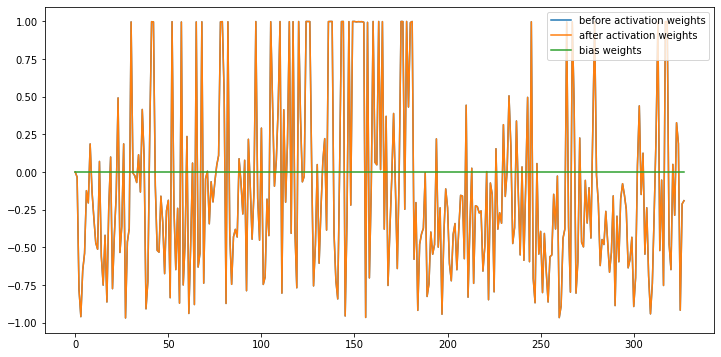

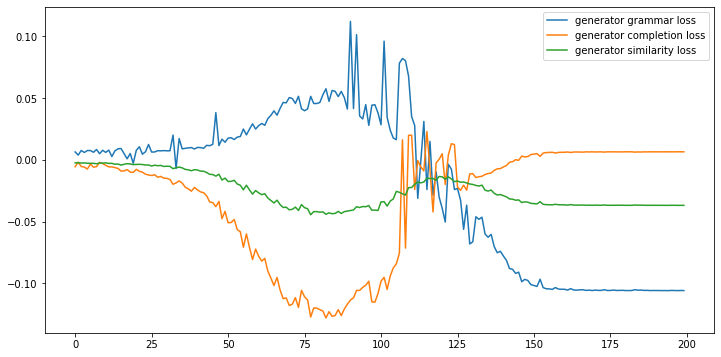

--------------------------------------------------
gold summary:

--------------------------------------------------
sam_wgan summary:
걱정되었어요. 딸을 데리고 자기 못마땅했어요. 종일 집안일을 난롯가에 앉아서 했지요. 신데렐라도 울기 가고 마법사 빙그레 내가 호박 한개와 생쥐 지팡이로 호박을 건드리자, 변했어요. 이번에는 건드렸어요. 생쥐는 흰말로, 도마뱀은 멋진 마부로 변했답니다. 신데렐라의 구슬 예쁜 신데렐라, 내밀어 신데렐라, 밤 되면 처음대로 돌아간단다. 주울 이 주인과 발을 맞았어요. 데리고 갔어요.
--------------------------------------------------
     method  comp ratio     intro  ...      var     total   grammar
0  SAM+WGAN    0.147099  0.522104  ...  0.00156  0.587503  0.987526

[1 rows x 8 columns]


In [113]:
df1,_ = sam_wgan('',[org_text_1,org_text_2,org_text_3],init_bias=0.0,display= True)
print(df1)